In [1]:
import scipy
import scipy.io
import scipy.integrate
import scipy.signal
from scipy.signal import argrelextrema
import numpy as np
from numpy import linalg
from pydmd import DMD
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
import math

In [2]:
#mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\Airfoil Data\A0PIVairfoil.mat')
mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\Airfoil Data\A0PIVuv.mat')

data = list(mat.items())

u = data[7]
v = data[8]
u_mean = data[9]
v_mean = data[10]
x = data[11]
y = data[12]
ts = data[3][1][0][0] # time step between snapshots
print(data[7][0],data[8][0])
print(data[9][0],data[10][0])
print(data[11][0],data[12][0])

u v
u_mean v_mean
x y


In [47]:
samples = len(u[1])             # number of snapshots in input data

h = len(u[1][1][1])             # height of matrix = y
l = len(u[1][1])                # length of matrix = x
h_trunc = 35                    # y truncation for input data
l_trunc = 130-25                   # x truncation for input data
n_modes = 10
t_trunc = 500                  # number of time snapshots for SVD # samples
size = h_trunc*l_trunc
# t = np.linspace(0, t_trunc, ts) #time scale

print(h,l,samples,t_trunc)

66 186 6998 500


In [48]:
#print(x[1]) # [name "x"] __ [186 x coord arrays] __ [66 identical values]
xs = []
for i in range(0, l_trunc):
    #xs.append(x[1][i][1])
    #xs.append(x[1][i][1])
    xs.append(i)
    
ys = []
for i in range(0,h_trunc*2):
    ys.append(i)
#ys = y[1][1][0:(h_trunc)]

print(len(xs))
print(len(ys))
print(len(xs)*len(ys))
#xsgrid, ysgrid = np.meshgrid(xs, ys)

105
70
7350


(6998, 70, 105)


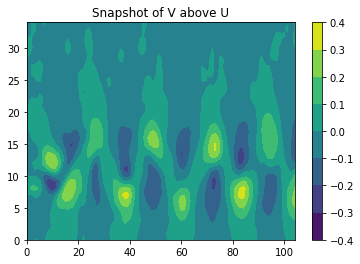

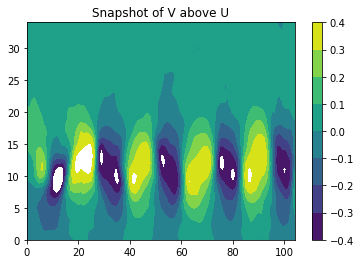

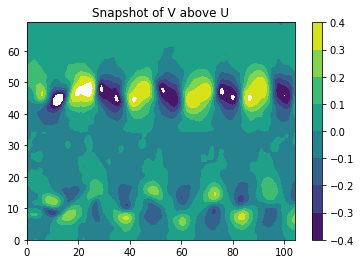

In [56]:
X = np.empty([t_trunc,h_trunc*2,l_trunc])
print(np.shape(X))
for i in range(0,t_trunc): # truncating to time resolution
    X_man = np.rot90(u[1][i],3) # U dataset already has mean subtracted
    X_man = np.delete(X_man, np.s_[h_trunc::], 0) # from top left, slice row 0:h. Parameter of 0 in np.delete defines rows
    X_man = np.delete(X_man, np.s_[0:l-l_trunc], 1) # from top left, slice column 0:l. Parameter of 1 in np.delete defines columns
    #print(np.shape(X_man))
    Y_man = np.rot90(v[1][i]-v_mean[1][0],3) # V dataset requires mean to be subtracted
    Y_man = np.delete(Y_man, np.s_[h_trunc::], 0) # from top left, slice row 0:h. Parameter of 0 in np.delete defines rows
    Y_man = np.delete(Y_man, np.s_[0:l-l_trunc], 1) # from top left, slice column 0:l. Parameter of 1 in np.delete defines columns
    
    X[i,:,:] = np.append(X_man, Y_man, axis=0)
    
fig, ax = plt.subplots()
levels = np.linspace(-0.4, 0.4, 9)
cs = ax.contourf(X_man, levels = levels)
ax.set_title('Snapshot of V above U')
fig.colorbar(cs, ax=ax)
plt.plot()
fig.canvas.draw()

fig, ax = plt.subplots()
levels = np.linspace(-0.4, 0.4, 9)
cs = ax.contourf(Y_man, levels = levels)
ax.set_title('Snapshot of V above U')
fig.colorbar(cs, ax=ax)
plt.plot()
fig.canvas.draw()

fig, ax = plt.subplots()
levels = np.linspace(-0.4, 0.4, 9)
cs = ax.contourf(X[0,:,:], levels = levels)
ax.set_title('Snapshot of V above U')
fig.colorbar(cs, ax=ax)
plt.plot()
fig.canvas.draw()


# use 500 snapshots to debug
# verify mean subtraction
# 

(6998, 70, 105)
(7350, 500)


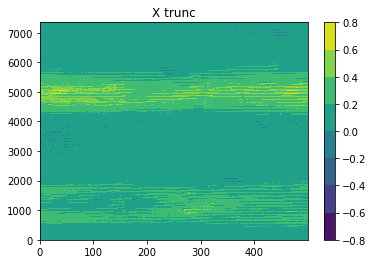

In [50]:
print(np.shape(X))
# reshape X to contain all velocity points in second matrix dimension
# transpose to align spatial points vertically, time horizontally
X_trunc = np.transpose(np.reshape(X, (t_trunc,l_trunc*h_trunc*2)))
print(np.shape(X_trunc))

fig, ax = plt.subplots()
cs = ax.contourf(X_trunc)
ax.set_title('X trunc')
fig.colorbar(cs, ax=ax)
plt.plot()
fig.canvas.draw()  

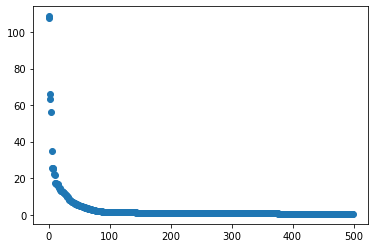

In [51]:
fig = plt.plot(scipy.linalg.svdvals(np.array([i.flatten() for i in X_trunc]).T), 'o')

In [52]:
dmdX = DMD(svd_rank=n_modes, tlsq_rank=0, exact=True, opt=True) #svd_rank of 0 auto-selects truncation rank. In some cases, 
#singular values should be examined in order to select the proper truncation.

dmdX.fit(X_trunc)

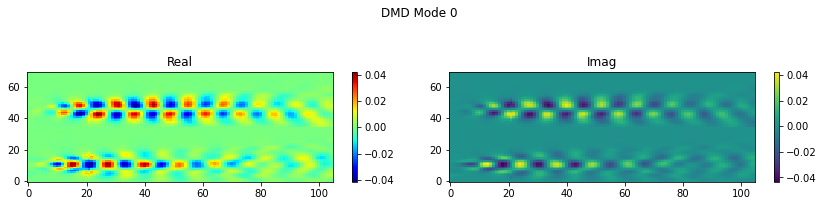

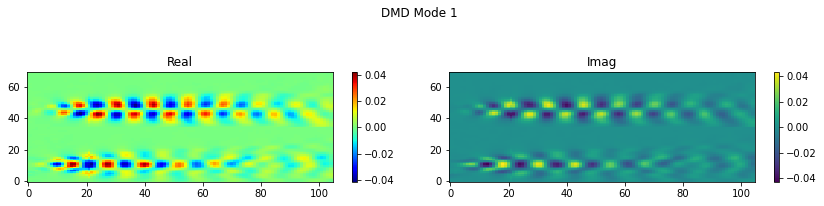

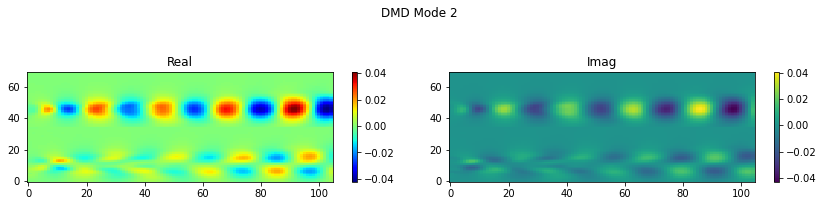

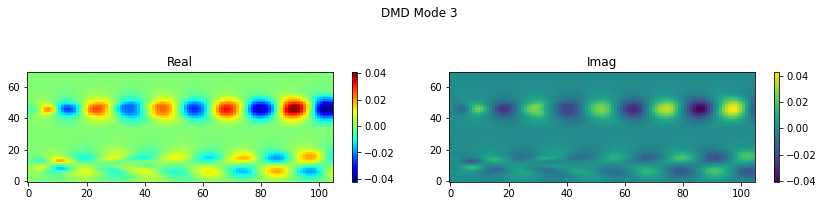

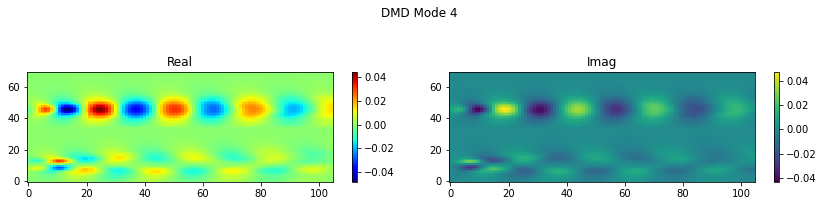

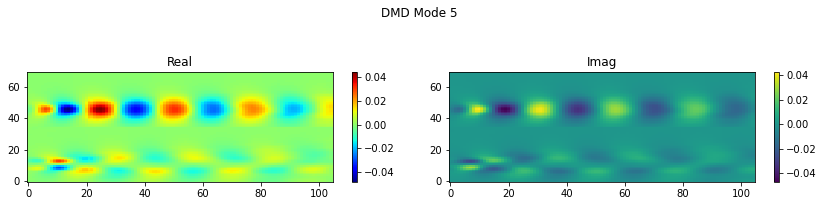

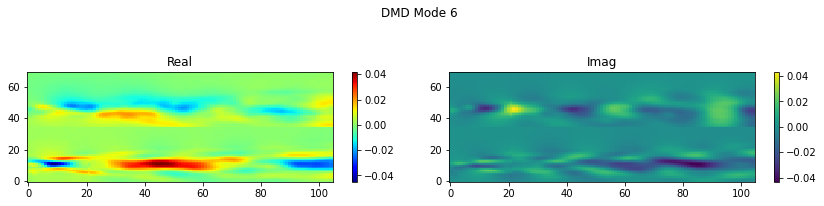

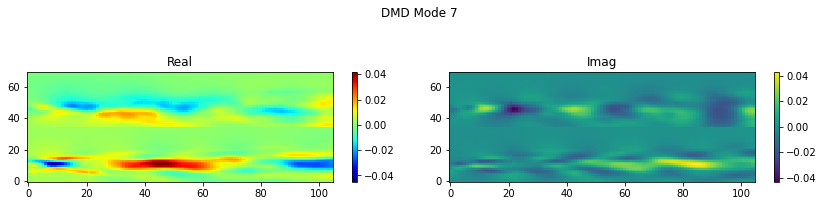

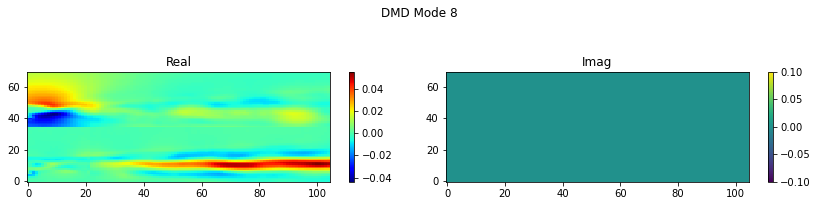

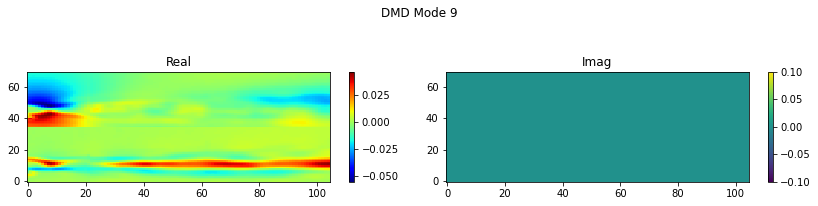

In [53]:
dmdX.plot_modes_2D(x=xs, y=ys, figsize=(12,3))

In [54]:
import csv
filename = "dmd_0_VU_stack.csv"
with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(np.rot90(dmdX.modes.imag))
    csvwriter.writerows(np.rot90(dmdX.modes.real))

In [37]:
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

NameError: name 'dmd' is not defined

In [ ]:
for mode in dmd.modes.T:
    plt.plot(mode.real)
    plt.title('Modes')
plt.show()

t = np.linspace(0, samples*ts, samples)
i=0
for dynamic in dmd.dynamics:
    plt.ylim(-4.5, 4.5)
    plt.xlim(0, 5)
    plt.plot(t, dynamic.real, label='Mode '+str(i+1))
    plt.title('Dynamics')
    i = i+1
plt.xlabel('Time (s)')
plt.ylabel('Relative Amplitude')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [ ]:
# Source: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html
from numpy.fft import fft, ifft # using fast fourier transform to find the discrete frequencies of the signal

#mode_no = [0,1,2,3,4,5]
mode_no = [5,6,7,8,9,9]

Freq0 = np.flip(fft(dmd.dynamics.real[mode_no[0]]))
Freq1 = np.flip(fft(dmd.dynamics.real[mode_no[1]]))
Freq2 = np.flip(fft(dmd.dynamics.real[mode_no[2]]))
Freq3 = np.flip(fft(dmd.dynamics.real[mode_no[3]]))
Freq4 = np.flip(fft(dmd.dynamics.real[mode_no[4]]))
Freq5 = np.flip(fft(dmd.dynamics.real[mode_no[5]]))

N = len(Freq0)
n = np.arange(N/2)
sr = 1/ts # sampling rate, Hz
t = np.arange(0,N/sr,ts)
# Get the one-sided specturm
n_oneside = int(N/2)+1
# get the one side frequency
f_oneside = n*2*np.pi*sr/(2*n_oneside)
xmax = 40 #sr

fig, (plt0,plt1,plt2,plt3,plt4,plt5) = plt.subplots(6, figsize = (6,15))
plt.rc('font', size=13) #controls default text size

plt0.plot(f_oneside, np.abs(Freq0[:n_oneside]), 'r')
plt1.plot(f_oneside, np.abs(Freq1[:n_oneside]), 'g')
plt2.plot(f_oneside, np.abs(Freq2[:n_oneside]), 'b')
plt3.plot(f_oneside, np.abs(Freq3[:n_oneside]), 'y')
plt4.plot(f_oneside, np.abs(Freq4[:n_oneside]), 'c')
plt5.plot(f_oneside, np.abs(Freq5[:n_oneside]), 'm')
#plt0.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt1.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt2.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt3.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt4.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt5.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
plt0.set_xlim(0, xmax)
plt1.set_xlim(0, xmax)
plt2.set_xlim(0, xmax)
plt3.set_xlim(0, xmax)
plt4.set_xlim(0, xmax)
plt5.set_xlim(0, xmax)

plt0.set_xlabel('Frequency (Hz)')
plt0.set_ylabel('FFT Amplitude |VT(freq)|')
plt1.set_xlabel('Frequency (Hz)')
plt1.set_ylabel('FFT Amplitude |VT(freq)|')
plt2.set_xlabel('Frequency (Hz)')
plt2.set_ylabel('FFT Amplitude |VT(freq)|')
plt3.set_xlabel('Frequency (Hz)')
plt3.set_ylabel('FFT Amplitude |VT(freq)|')
plt4.set_xlabel('Frequency (Hz)')
plt4.set_ylabel('FFT Amplitude |VT(freq)|')
plt5.set_xlabel('Frequency (Hz)')
plt5.set_ylabel('FFT Amplitude |VT(freq)|')

plt0.set_title('Mode ' + str(mode_no[0]+1) + ' coefficient frequency')
plt1.set_title('Mode ' + str(mode_no[1]+1) + ' coefficient frequency')
plt2.set_title('Mode ' + str(mode_no[2]+1) + ' coefficient frequency')
plt3.set_title('Mode ' + str(mode_no[3]+1) + ' coefficient frequency')
plt4.set_title('Mode ' + str(mode_no[4]+1) + ' coefficient frequency')
plt5.set_title('Mode ' + str(mode_no[5]+1) + ' coefficient frequency')

plt.tight_layout()
plt.show()

In [ ]:
peaks = np.zeros(n_modes)
for i in range(0,n_modes):
    Freq = np.flip(fft(dmd.dynamics.real[i]))
    plt.plot(Freq)
    try:
        f = (argrelextrema(Freq, np.greater)[0][0]+argrelextrema(Freq, np.less)[0][0])/2*2*np.pi*sr/(2*n_oneside)
        if f < 100:
            peaks[i] = (f)
        else:
            peaks[i] = 0
    except:
        peaks[i] = 0
print(peaks, type(peaks))
plt.show()

np.savetxt('dmd_freqs_0.csv', peaks, delimiter = ',')